In [399]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import pathlib
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from Agents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from Environments import DeepSea, WideNarrow, PriorMDP
from utils import solve_tabular_continuing_PI, run_experiment, run_oracle_experiment, load_agent

from tqdm import tqdm_notebook as tqdm

# For saving figures and agents
if not os.path.exists('results'): os.mkdir('results')
if not os.path.exists('results/figures'): os.mkdir('results/figures')
if not os.path.exists('results/agent_logs'): os.mkdir('results/agent_logs')

fig_loc = 'results/figures/'

# Plotting parameters
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

# Environment constants

In [400]:
# Widenarrow constants
num_time_steps = 5000
save_every = num_time_steps // 100

N = 1
W = 4

mu_l, mu_h = 0.0, 0.5
sig_l, sig_h = 1.0, 1.0

rew_params = ((mu_l, sig_l), (mu_h, sig_h), (mu_l, sig_l))
env_params = {'N'          : N,
              'W'          : W,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)

# Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
max_iter = 4 * N
max_buffer_length = 2 * N + 1

# Q-Learning

In [401]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'dither_mode'      : 'epsilon-greedy',
                'dither_param'     : 0.2,
                'lr'               : 0.1,
                'Q0'               : 0.0,
                'anneal_timescale' : float('inf'),
                'sa_list'          : environment.sa_list()}

In [402]:
for seed in tqdm(range(10)):

    # Define agent
    agent = QLearningAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=1,
                   save_every=save_every)

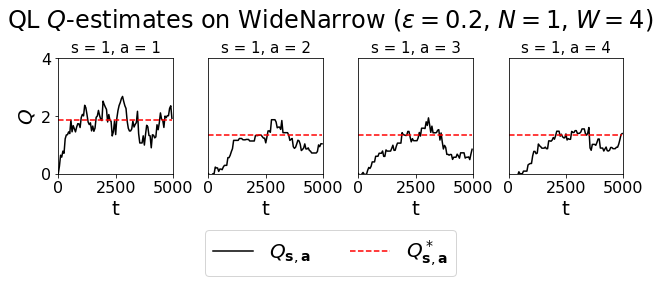

In [403]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, QLearningAgent(agent_params), seed=0)

means = []
for t in np.arange(num_time_steps // save_every):

    means.append([])
    for s in [0]:
        
        means[-1].append([])
        for a in range(W):
            
            means[-1][-1].append(agent.Qlog[t][s][a])
            
means = np.array(means)

fig = plt.figure(figsize=(9, 4))

actions = ['left', 'right']
leg_names = ['$Q_{\mathbf{s}, \mathbf{a}}$', '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 2
s, a = 0, 0

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='black')
        
        leg[1], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
        
        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.xlim([0, num_time_steps])
        plt.xlabel('t', fontsize=20)
        
        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$Q$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
            
fig.suptitle('QL $Q$-estimates on WideNarrow ($\epsilon = 0.2$, $N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)

save_name = 'ql-{}-qestimates-widenarrow-{}-{}'.format(agent.dither_param, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

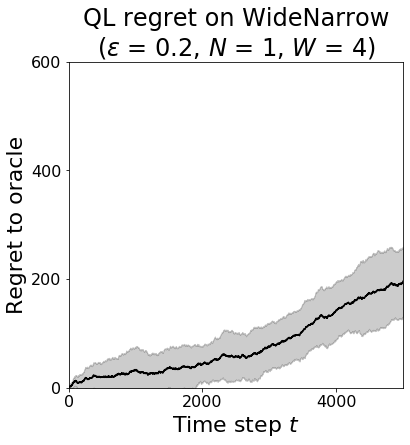

In [404]:
agent_rs, oracle_rs = [], []

for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, QLearningAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color='k')
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color='k', alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('QL regret on WideNarrow\n($\epsilon$ = {}, $N$ = {}, $W$ = {})'.format(agent.dither_param, N, W),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.ylim([0, 600])

save_name = 'ql-{}-regret-widenarrow-{}-{}'.format(agent.dither_param, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Bayesian Q-Learning

In [407]:
# Agent parameters
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 1.5,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

In [408]:
for seed in tqdm(range(10)):

    # Define agent
    agent =  BayesianQAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=1,
                   save_every=save_every)

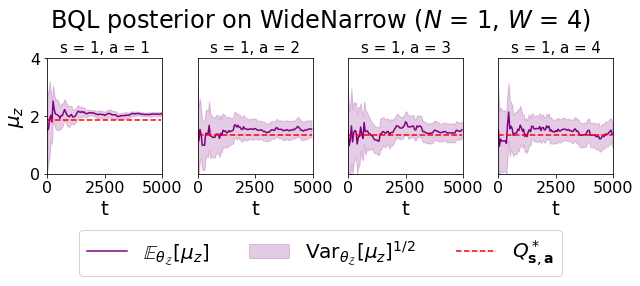

In [409]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

means, stds = [], []

agent = load_agent(environment, BayesianQAgent(agent_params), seed=0)

for t in np.arange(num_time_steps // save_every):
    
    means.append([])
    stds.append([])
    
    for s in [0]:
        
        means[-1].append([])
        stds[-1].append([])
        
        for a in range(W):
            mu, lamda, alpha, beta = agent.Qpost_log[t][s][a]
            var = beta / (lamda * (alpha - 1))
            
            means[-1][-1].append(mu)
            stds[-1][-1].append(var**0.5)
            
means, stds = np.array(means), np.array(stds)

fig = plt.figure(figsize=(9, 4))

actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{Z}}}[\mu_z]$',
             'Var$_{\\theta_{\mathcal{Z}}}[\mu_z]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every, means[:, s, a], color='purple')
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every, 
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color='purple', alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')
            
        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_z$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('BQL posterior on WideNarrow ($N$ = {}, $W$ = {})'.format(N, W), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-posterior-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

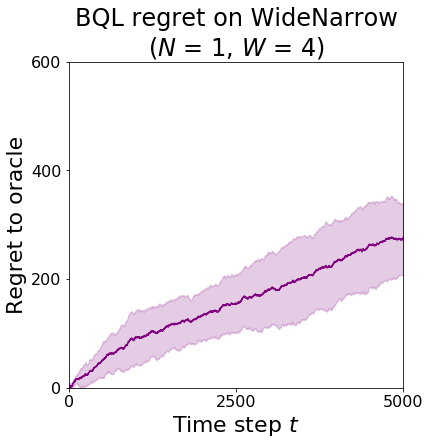

In [410]:
color = 'purple'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, BayesianQAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('BQL regret on WideNarrow\n($N$ = {}, $W$ = {})'.format(N, W), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 600])

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-regret-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [411]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'max_iter'         : max_iter,
                'sa_list'          : environment.sa_list()}

In [412]:
for seed in tqdm(range(10)):
    
    # Define agent
    agent = PSRLAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

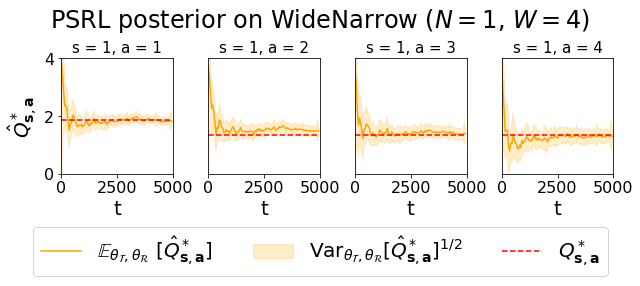

In [413]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, PSRLAgent(agent_params), seed=0)

Qs = []
for t in np.arange(num_time_steps // save_every):
          
    Qs.append([])
    
    for i in range(100):
        agent.Ppost, agent.Rpost = agent.Ppost_log[t], agent.Rpost_log[t]
        P, R = agent.sample_posterior()
        pi, Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)
        Qs[-1].append(Q_)
            
Qs = np.array(Qs)
means = np.mean(Qs, axis=1)
stds = np.var(Qs, axis=1)**0.5

P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

fig = plt.figure(figsize=(9, 4))

color = 'orange'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}~[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\hat{Q}^*_{\mathbf{s}, \mathbf{a}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                          np.ones(len(means[:, s, a])) * Q[s, a], 
                          '--',
                          color='red')

        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\hat{Q}^*_{\mathbf{s}, \mathbf{a}}$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('PSRL posterior on WideNarrow ($N = 1$, $W = 4$)', fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
plt.tight_layout(w_pad=1)
fig.subplots_adjust(top=0.8, bottom=0.4)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-posterior-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

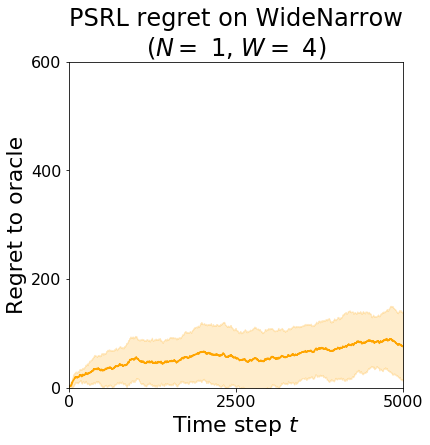

In [414]:
color = 'orange'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = PSRLAgent(agent_params)
    agent = load_agent(environment, agent, seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('PSRL regret on WideNarrow\n($N =$ {}, $W =$ {})'.format(N, W), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 600])

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-regret-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, N, W).replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [415]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [416]:
for seed in tqdm(range(10)):
    
    # Define agent
    agent = UbeNoUnrollAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

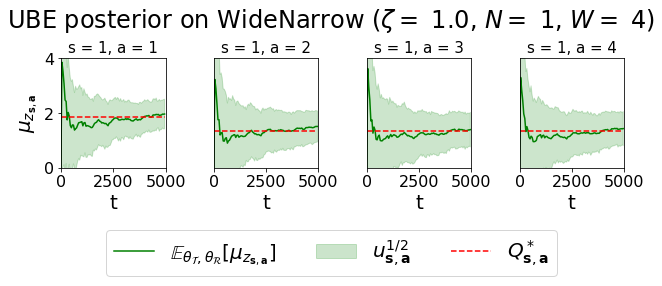

In [417]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
                
    means.append(agent.Qmu_log[t])
    stds.append(agent.Qvar_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(9, 4))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']

leg = [None] * 3

s, a = 0, 0

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
        
        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.xlabel('t', fontsize=20)
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_{z_{\mathbf{s}, \mathbf{a}}}$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)   
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('UBE posterior on WideNarrow ($\zeta =$ {}, $N =$ 1, $W =$ 4)'.format(agent.zeta, N, W), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.8, bottom=0.42)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-posterior-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

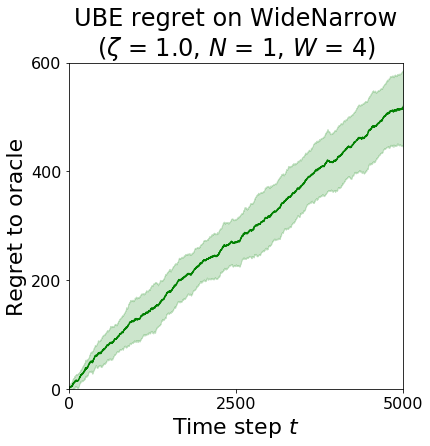

In [418]:
color = 'green'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE regret on WideNarrow\n($\zeta$ = {}, $N$ = {}, $W$ = {})'.format(agent.zeta, N, W),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 600])

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-regret-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [428]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [429]:
for seed in tqdm(range(10)):

    # Define agent
    agent = UbeNoUnrollAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

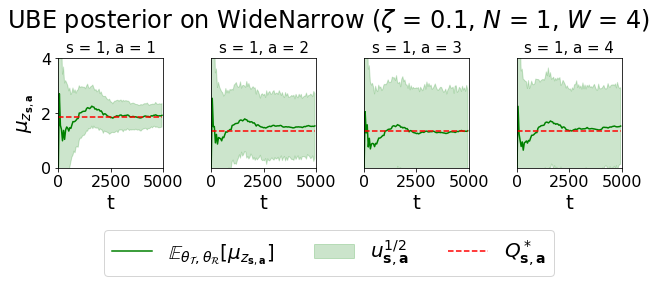

In [430]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)

means, stds = [], []
for t in np.arange(num_time_steps // save_every):
                
    means.append(agent.Qmu_log[t])
    stds.append(agent.Qvar_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(9, 4))

color = 'green'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z_{\mathbf{s}, \mathbf{a}}}]$',
             '$u^{1/2}_{\mathbf{s}, \mathbf{a}}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3
s, a = 0, 0

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
        
        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.xlabel('t', fontsize=20)
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_{z_{\mathbf{s}, \mathbf{a}}}$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)   
        plt.xlabel('t', fontsize=20)
            
fig.suptitle('UBE posterior on WideNarrow ($\zeta$ = {}, $N$ = {}, $W$ = {})'.format(agent.zeta, N, W), fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.8, bottom=0.42)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-posterior-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

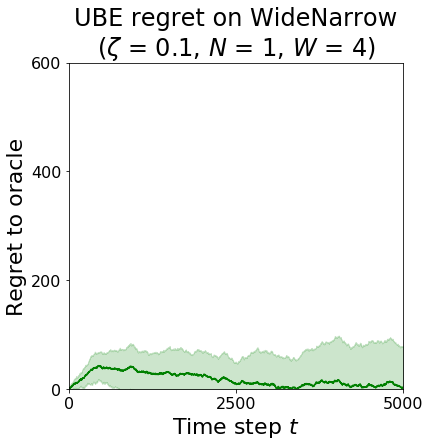

In [422]:
color = 'green'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5

plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('UBE regret on WideNarrow\n($\zeta$ = {}, $N$ = {}, $W$ = {})'.format(agent.zeta, N, W), fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 600])

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-regret-widenarrow-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Moment Matching

In [423]:
# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

In [424]:
for seed in tqdm(range(10)):

    # Define agent
    agent = MomentMatchingAgent(agent_params)

    # Run experiment
    run_experiment(environment=environment,
                   agent=agent,
                   seed=seed,
                   num_time_steps=num_time_steps,
                   max_buffer_length=max_buffer_length,
                   save_every=save_every)

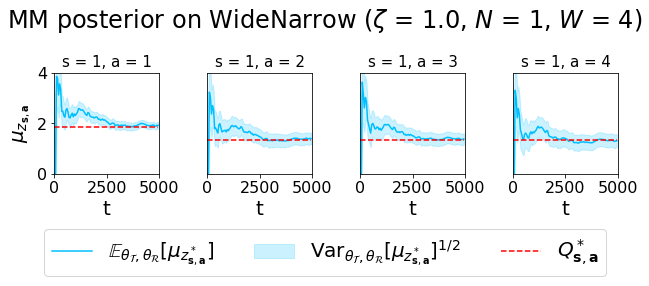

In [425]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=0)
means, stds = [], []
for t in np.arange(num_time_steps // save_every):
    
    means.append(agent.mu_log[t])
    stds.append(agent.var_log[t]**0.5)
            
means = np.array(means)
stds = np.array(stds)

fig = plt.figure(figsize=(9, 4))

color = 'deepskyblue'
actions = ['left', 'right']
leg_names = ['$\mathbb{E}_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^*_{\mathbf{s}, \mathbf{a}}}]$',
             'Var$_{\\theta_{\mathcal{T}}, \\theta_{\mathcal{R}}}[\mu_{z^*_{\mathbf{s}, \mathbf{a}}}]^{1/2}$',
             '$Q^*_{\mathbf{s}, \mathbf{a}}$']
leg = [None] * 3

for n in range(N):
    for w in range(W):
        
        if w == W:
            s, a = 2 * n + 1, 0
        else:
            s, a = 2 * n, w
        
        plt.subplot(N, W, n * W + w + 1)
        
        leg[0], = plt.plot(np.arange(len(means[:, s, a])) * save_every,
                           means[:, s, a],
                           color=color)
        leg[1] = plt.fill_between(np.arange(len(means[:, s, a])) * save_every,
                                   means[:, s, a] + stds[:, s, a],
                                   means[:, s, a] - stds[:, s, a],
                                   color=color, alpha=0.2)
        
        leg[2], = plt.plot(np.arange(len(means[:, s, a])) * save_every, 
                           np.ones(len(means[:, s, a])) * Q[s, a], 
                           '--',
                           color='red')
          
        plt.ylim([0, 4])
        plt.yticks([0, 2, 4])
        plt.xlim([0, len(means[:, s, a])])
        plt.xticks([0, num_time_steps // 2, num_time_steps])
        plt.tight_layout()

        if w > 0:
            plt.yticks([])
        else:
            plt.ylabel('$\mu_{z_{\mathbf{s}, \mathbf{a}}}$', fontsize=20)
        
        plt.title(r's = {}, a = {}'.format(s + 1, a + 1), fontsize=15)   
        plt.xlabel('t', fontsize=20)      
            
fig.suptitle('MM posterior on WideNarrow ($\zeta$ = {}, $N$ = {}, $W$ = {})'.format(agent.zeta, N, W),
             fontsize=24)
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=3, labelspacing=0., fontsize=20)
fig.subplots_adjust(top=0.75, bottom=0.4)
plt.show()

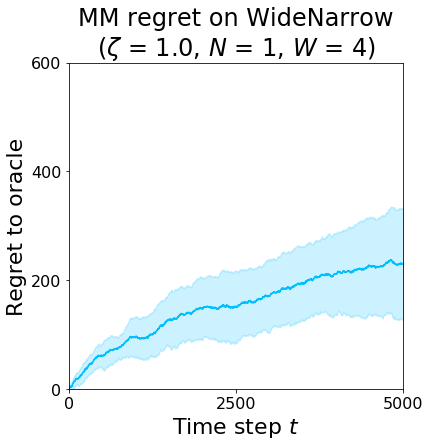

In [426]:
color = 'deepskyblue'

agent_rs, oracle_rs = [], []
for seed in range(10):
    
    # Define agent
    agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=seed)
    
    agent_rs.append(agent.train_r)

    oracle_r = run_oracle_experiment(environment=environment,
                                     seed=seed,
                                     gamma=0.9,
                                     num_time_steps=num_time_steps,
                                     num_PI_iter=max_iter)[2]
    
    oracle_rs.append(oracle_r)
    
agent_rs, oracle_rs = np.array(agent_rs), np.array(oracle_rs)

regrets = np.cumsum(oracle_rs - agent_rs, axis=-1)
means = np.mean(regrets, axis=0)
stds = np.var(regrets, axis=0)**0.5
plt.figure(figsize=(6, 6))
plt.plot(means, color=color)
plt.fill_between(np.arange(len(means)), means - stds, means + stds, color=color, alpha=0.2)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.title('MM regret on WideNarrow\n($\zeta$ = {}, $N$ = {}, $W$ = {})'.format(agent.zeta, N, W),
          fontsize=24)
plt.xlabel('Time step $t$', fontsize=22)
plt.ylabel('Regret to oracle', fontsize=22)
plt.xlim([0, num_time_steps])
plt.xticks([0, num_time_steps // 2, num_time_steps])
plt.ylim([0, 600])
plt.show()